# 05 — Time Series Forecasting with ARIMA (PM2.5)
Mục tiêu:
- Làm sạch + chuẩn hoá chuỗi theo tần suất giờ (hourly) và xử lý missing.
- Kiểm tra **trend / seasonality / stationarity** (ADF, KPSS), ACF/PACF.
- Chọn tham số **(p,d,q)** bằng grid nhỏ (AIC/BIC) và dự báo bằng **ARIMA**.

> Lưu ý: Notebook này **chỉ dùng ARIMA** (statsmodels). 


In [1]:
from pathlib import Path
USE_UCIMLREPO = False
RAW_ZIP_PATH = 'data/raw/PRSA2017_Data_20130301-20170228.zip'
PROJECT_ROOT = Path().resolve()   # hoặc Path.cwd().resolve()
RAW_ZIP_PATH = str((PROJECT_ROOT / RAW_ZIP_PATH).resolve())
STATION = 'Aotizhongxin'
VALUE_COL = 'PM2.5'
CUTOFF = '2017-01-01'

P_MAX = 3
Q_MAX = 3
D_MAX = 2
IC = 'aic'   # 'aic' or 'bic'

ARTIFACTS_PREFIX = 'arima_pm25'


In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Add project root to path so src can be imported
PROJECT_ROOT = Path().resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Try to import from src, if fails check parent directory
try:
    from src.classification_library import (
        load_beijing_air_quality,
        clean_air_quality_df,
    )
    from src.timeseries_library import (
        StationSeriesConfig,
        make_hourly_station_series,
        describe_time_series,
        train_test_split_series,
        grid_search_arima_order,
        fit_arima_and_forecast,
    )
except ModuleNotFoundError:
    # If src is not found, try parent directory
    parent_root = PROJECT_ROOT.parent
    if str(parent_root) not in sys.path:
        sys.path.insert(0, str(parent_root))
    from src.classification_library import (
        load_beijing_air_quality,
        clean_air_quality_df,
    )
    from src.timeseries_library import (
        StationSeriesConfig,
        make_hourly_station_series,
        describe_time_series,
        train_test_split_series,
        grid_search_arima_order,
        fit_arima_and_forecast,
    )

# NOTE:
# - PROJECT_ROOT và RAW_ZIP_PATH được khai báo ở cell PARAMETERS (papermill chạy cell này trước).
# - Không override PROJECT_ROOT bằng Path('..') vì sẽ lệch khi chạy từ terminal / papermill.
try:
    PROJECT_ROOT
except NameError:
    from pathlib import Path
    PROJECT_ROOT = Path().resolve()

try:
    RAW_ZIP_PATH
except NameError:
    RAW_ZIP_PATH = str((PROJECT_ROOT / "data/raw/PRSA2017_Data_20130301-20170228.zip").resolve())

print("PROJECT_ROOT =", PROJECT_ROOT)
print("RAW_ZIP_PATH =", RAW_ZIP_PATH)


PROJECT_ROOT = C:\Users\quang\OneDrive\Desktop\Code\KPDL\Lab4\notebooks
RAW_ZIP_PATH = C:\Users\quang\OneDrive\Desktop\Code\KPDL\Lab4\notebooks\data\raw\PRSA2017_Data_20130301-20170228.zip


## 1) Load + clean + build 1 chuỗi theo station
Chúng ta dự báo **một** chuỗi (một trạm) để ARIMA đúng nghĩa univariate.

In [4]:
# Correct the path to point to parent directory
from pathlib import Path
corrected_zip_path = str((parent_root / "data/raw/PRSA2017_Data_20130301-20170228.zip").resolve())
print(f"Loading from: {corrected_zip_path}")

df = load_beijing_air_quality(use_ucimlrepo=False, raw_zip_path=corrected_zip_path)
df = clean_air_quality_df(df)
cfg = StationSeriesConfig(station=STATION, value_col=VALUE_COL, freq='H', fill_method='interpolate_time')
s = make_hourly_station_series(df, cfg)
print('series length:', len(s))
print('start/end:', s.index.min(), s.index.max())


Loading from: C:\Users\quang\OneDrive\Desktop\Code\KPDL\Lab4\data\raw\PRSA2017_Data_20130301-20170228.zip
series length: 35064
start/end: 2013-03-01 00:00:00 2017-02-28 23:00:00


C:\Users\quang\OneDrive\Desktop\Code\KPDL\Lab4\src\timeseries_library.py:55: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  s = s.resample(cfg.freq).mean()


## 2) EDA + Diagnostics (trend, seasonality, stationarity)
Các tín hiệu cần quan sát để ra quyết định:
- Missing gaps (dữ liệu cảm biến hay thiếu)
- Seasonality theo **24h** và **7 ngày** (weekly)
- Stationarity: nếu không dừng -> cần differencing (d)


{
  "n": 35064,
  "missing_ratio": 0.0,
  "min": 3.0,
  "max": 898.0,
  "mean": 82.54062286105409,
  "std": 81.95640129983177,
  "adf_pvalue": 0.0,
  "kpss_pvalue": 0.1,
  "autocorr_lag_24": 0.40157518039673334,
  "autocorr_lag_168": 0.016796754924567916
}


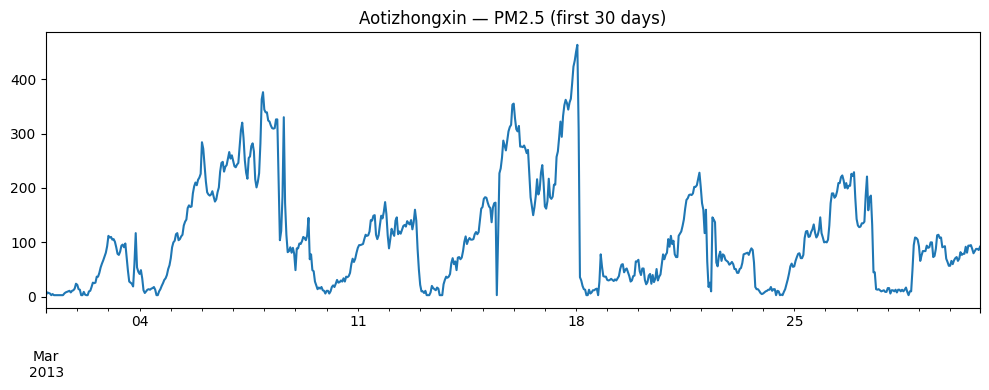

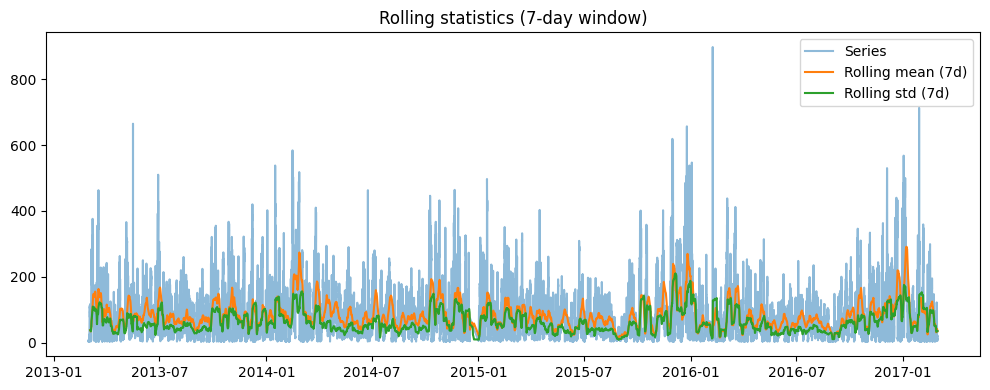

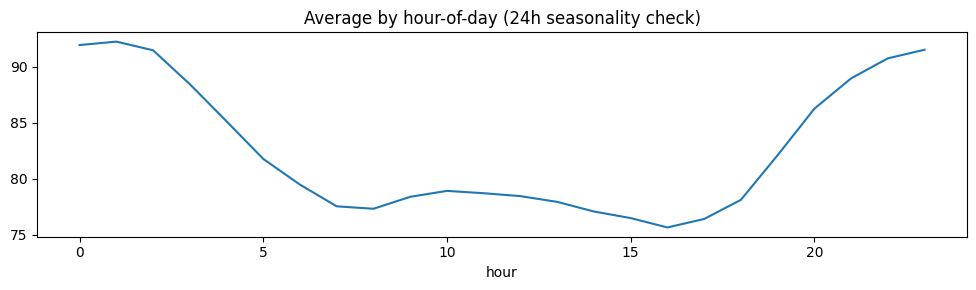

In [5]:
diag = describe_time_series(s)
print(json.dumps(diag, ensure_ascii=False, indent=2))

# Plot raw series (zoom a bit)
plt.figure(figsize=(10,4))
s.iloc[:24*30].plot()  # first 30 days
plt.title(f'{STATION} — {VALUE_COL} (first 30 days)')
plt.tight_layout()
plt.show()

# Rolling mean/std for intuition about stationarity
roll_mean = s.rolling(24*7, min_periods=24*3).mean()  # 7-day window
roll_std  = s.rolling(24*7, min_periods=24*3).std()
plt.figure(figsize=(10,4))
plt.plot(s.index, s.values, label='Series', alpha=0.5)
plt.plot(roll_mean.index, roll_mean.values, label='Rolling mean (7d)')
plt.plot(roll_std.index, roll_std.values, label='Rolling std (7d)')
plt.title('Rolling statistics (7-day window)')
plt.legend()
plt.tight_layout()
plt.show()

# Seasonality check: average by hour-of-day
tmp = pd.DataFrame({'y': s.values}, index=s.index)
hod = tmp.groupby(tmp.index.hour)['y'].mean()
plt.figure(figsize=(10,3))
plt.plot(hod.index, hod.values)
plt.title('Average by hour-of-day (24h seasonality check)')
plt.xlabel('hour')
plt.tight_layout()
plt.show()


## 3) Split theo thời gian + ACF/PACF (gợi ý p, q)
ACF/PACF giúp nhìn cấu trúc tương quan theo lag.
Trong thực tế ta vẫn cần kiểm chứng bằng AIC/BIC.

train: 2013-03-01 00:00:00 -> 2016-12-31 23:00:00 | n= 33648
test : 2017-01-01 00:00:00 -> 2017-02-28 23:00:00 | n= 1416


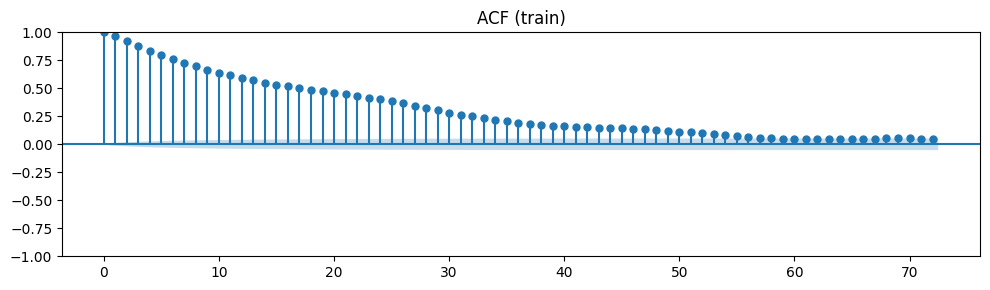

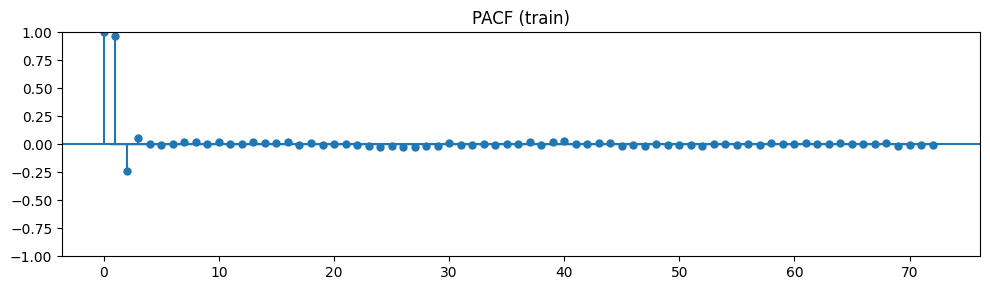

In [6]:
train, test = train_test_split_series(s, cutoff=CUTOFF)
print('train:', train.index.min(), '->', train.index.max(), '| n=', len(train))
print('test :', test.index.min(), '->', test.index.max(), '| n=', len(test))

x = train.dropna()
plt.figure(figsize=(10,3))
plot_acf(x, lags=72, ax=plt.gca())  # 3 days
plt.title('ACF (train)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plot_pacf(x, lags=72, ax=plt.gca(), method='ywm')
plt.title('PACF (train)')
plt.tight_layout()
plt.show()


## 4) Grid search ARIMA(p,d,q) theo AIC/BIC và dự báo
Giữ grid nhỏ để chạy nhanh trong lab.

Best order: (1, 0, 3) | best aic = 294792.706348293


,datetime,y_true,y_pred,lower,upper
0,2017-01-01 00:00:00,485.0,460.796484,422.895015,498.697953
1,2017-01-01 01:00:00,477.0,442.790204,383.069985,502.510423
2,2017-01-01 02:00:00,454.0,425.685614,351.185256,500.185972
3,2017-01-01 03:00:00,418.0,409.842475,324.425762,495.259189
4,2017-01-01 04:00:00,438.0,394.729760,300.472291,488.987228


{'rmse': 104.10353113572859, 'mae': 77.69129505019856}


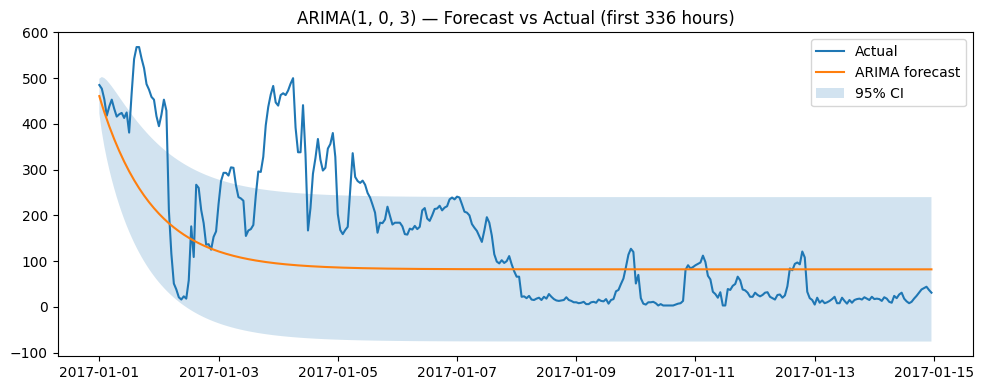

Saved: C:\Users\quang\OneDrive\Desktop\Code\KPDL\Lab4\notebooks\data\processed\arima_pm25_summary.json


In [7]:
gs = grid_search_arima_order(train, p_max=P_MAX, q_max=Q_MAX, d_max=D_MAX, d=None, ic=IC)
best_order = gs['best_order']
print('Best order:', best_order, '| best', IC, '=', gs['best_score'])

out = fit_arima_and_forecast(train, steps=len(test), order=best_order)
yhat = out['forecast']
ci = out['conf_int']

# Align with test index (same length)
pred_df = pd.DataFrame({
    'datetime': test.index[:len(yhat)],
    'y_true': test.values[:len(yhat)],
    'y_pred': yhat.values,
    'lower': ci.iloc[:,0].values,
    'upper': ci.iloc[:,1].values,
})
display(pred_df.head())

# Error metrics
mask = np.isfinite(pred_df['y_true']) & np.isfinite(pred_df['y_pred'])
rmse = float(np.sqrt(np.mean((pred_df.loc[mask,'y_true'] - pred_df.loc[mask,'y_pred'])**2)))
mae  = float(np.mean(np.abs(pred_df.loc[mask,'y_true'] - pred_df.loc[mask,'y_pred'])))
print({'rmse': rmse, 'mae': mae})

# Plot forecast (sample window)
plot_n = min(24*14, len(pred_df))  # first 14 days of test
p = pred_df.iloc[:plot_n].copy()
plt.figure(figsize=(10,4))
plt.plot(p['datetime'], p['y_true'], label='Actual')
plt.plot(p['datetime'], p['y_pred'], label='ARIMA forecast')
plt.fill_between(p['datetime'], p['lower'], p['upper'], alpha=0.2, label='95% CI')
plt.title(f'ARIMA{best_order} — Forecast vs Actual (first {plot_n} hours)')
plt.legend()
plt.tight_layout()
plt.show()

# Save artifacts
out_dir = (PROJECT_ROOT / 'data/processed')
out_dir.mkdir(parents=True, exist_ok=True)
pred_df.to_csv(out_dir / f'{ARTIFACTS_PREFIX}_predictions.csv', index=False)
out['result'].save(out_dir / f'{ARTIFACTS_PREFIX}_model.pkl')
summary = {
    'station': STATION,
    'value_col': VALUE_COL,
    'cutoff': CUTOFF,
    'best_order': best_order,
    'ic': IC,
    'best_score': gs['best_score'],
    'rmse': rmse,
    'mae': mae,
    'diagnostics': diag,
}
with open(out_dir / f'{ARTIFACTS_PREFIX}_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print('Saved:', out_dir / f'{ARTIFACTS_PREFIX}_summary.json')


## Q3: Quy Trình Ra Quyết Định ARIMA

Theo yêu cầu Q3, sinh viên cần chứng minh quy trình ARIMA theo 5 bước:

### Bước 1: Quan sát chuỗi gốc để nhận diện xu hướng và mùa vụ
- **Mục đích**: Hiểu tính chất tổng quan của chuỗi
- **Công cụ**:
  - Vẽ chuỗi toàn giai đoạn và zoom vào 1-2 tháng
  - Vẽ rolling mean và rolling std (cửa sổ 7 ngày)
  - Vẽ average by hour-of-day để kiểm tra seasonality 24h
- **Kết luận**: Xem chuỗi có xu hướng tăng/giảm? Có dao động theo chu kỳ?

### Bước 2: Kiểm định dừng bằng ADF/KPSS để chọn d
- **ADF (Augmented Dickey-Fuller)**:
  - H0: Chuỗi có unit root (không dừng)
  - p < 0.05 → Bác bỏ H0 → Chuỗi dừng
  - p > 0.05 → Không bác bỏ H0 → Chuỗi không dừng (cần differencing)
  
- **KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**:
  - H0: Chuỗi dừng
  - p > 0.05 → Không bác bỏ H0 → Chuỗi dừng
  - p < 0.05 → Bác bỏ H0 → Chuỗi không dừng (cần differencing)
  
- **Chiến lược chọn d**:
  - Nếu ADF p < 0.05 VÀ KPSS p > 0.05 → d = 0 (chuỗi đã dừng)
  - Nếu không → Thử d = 1 (differencing bậc 1)
  - Nếu vẫn không dừng → Thử d = 2

### Bước 3: Xem ACF/PACF để đoán giá trị ứng viên cho p và q
- **PACF → gợi ý p (AR order)**:
  - Nếu PACF "cắt" rõ sau lag k → p ≈ k
  - PACF giảm dần → Thử p = 0, 1, 2, 3
  
- **ACF → gợi ý q (MA order)**:
  - Nếu ACF "cắt" rõ sau lag k → q ≈ k
  - ACF giảm dần → Thử q = 0, 1, 2, 3

- **Lưu ý**: Trong thực tế, tín hiệu không sắc nét → Cần grid search

### Bước 4: Grid search với p, q nhỏ và chọn mô hình theo AIC/BIC
- **Giữ d cố định** (từ Bước 2)
- **Thử tất cả tổ hợp (p, d, q)** với:
  - p = 0, 1, 2, ..., P_MAX
  - q = 0, 1, 2, ..., Q_MAX
  
- **Tiêu chí chọn**:
  - AIC (Akaike Information Criterion): Cân bằng goodness-of-fit và độ phức tạp
  - BIC (Bayesian Information Criterion): Phạt mô hình phức tạp mạnh hơn AIC
  - Chọn mô hình có AIC/BIC **thấp nhất**

### Bước 5: Chẩn đoán phần dư (residual diagnostics)
- **Mục đích**: Kiểm tra mô hình đã bắt được cấu trúc chính chưa
- **Phương pháp**:
  - Vẽ ACF của residuals → Nếu gần white noise (không tương quan) → Tốt
  - Ljung-Box test → p > 0.05 → Residuals là white noise
  - QQ plot → Kiểm tra phân phối chuẩn của residuals
  
- **Kết luận**: Nếu residuals ≈ white noise → Mô hình đã bắt được pattern chính

QUY TRÌNH RA QUYẾT ĐỊNH ARIMA - Q3

[BƯỚC 1] QUAN SÁT CHUỖI GỐC
----------------------------------------------------------------------
Chuỗi: Aotizhongxin - PM2.5
Length: 35,064 hours
Period: 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Missing: 0 (0.00%)


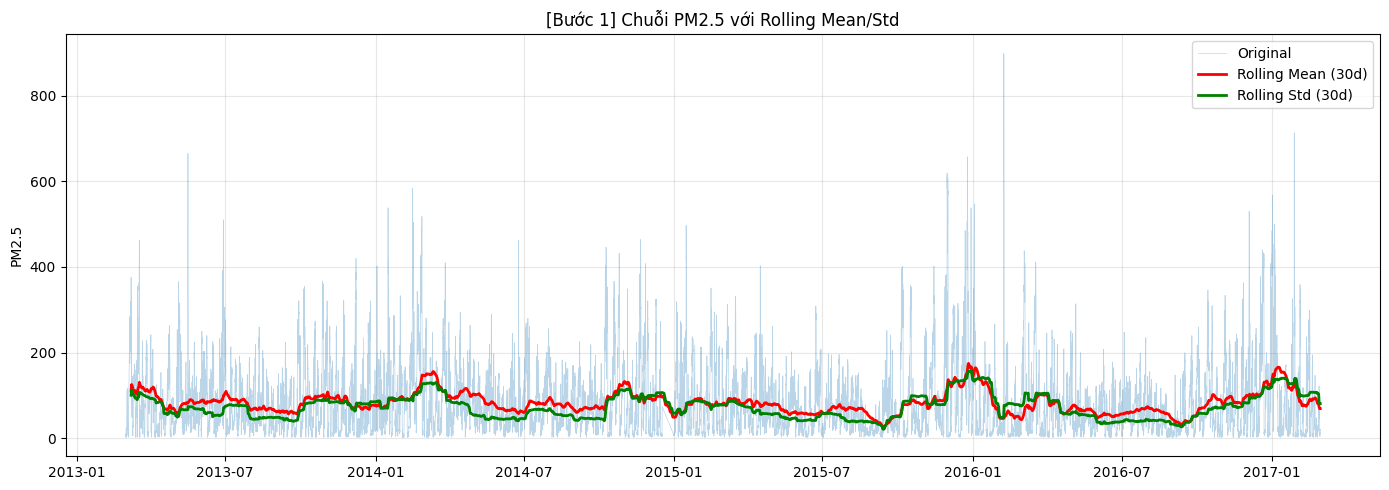


=> Nhận xét:
   - Rolling mean/std có thay đổi theo thời gian → Chuỗi có xu hướng không ổn định
   - Có các đỉnh spike cao → Cần lưu ý khi đánh giá


In [8]:
# Q3: Thực hiện quy trình ra quyết định ARIMA từng bước

print("="*70)
print("QUY TRÌNH RA QUYẾT ĐỊNH ARIMA - Q3")
print("="*70)

# BƯỚC 1: Quan sát chuỗi gốc
print("\n[BƯỚC 1] QUAN SÁT CHUỖI GỐC")
print("-"*70)
print(f"Chuỗi: {STATION} - {VALUE_COL}")
print(f"Length: {len(s):,} hours")
print(f"Period: {s.index.min()} to {s.index.max()}")
print(f"Missing: {s.isna().sum()} ({s.isna().mean()*100:.2f}%)")

# Rolling statistics để nhìn xu hướng
roll_mean_full = s.rolling(window=24*30, min_periods=24*7).mean()
roll_std_full = s.rolling(window=24*30, min_periods=24*7).std()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(s.index, s.values, alpha=0.3, linewidth=0.5, label='Original')
ax.plot(roll_mean_full.index, roll_mean_full.values, 'r-', linewidth=2, label='Rolling Mean (30d)')
ax.plot(roll_std_full.index, roll_std_full.values, 'g-', linewidth=2, label='Rolling Std (30d)')
ax.set_title(f'[Bước 1] Chuỗi {VALUE_COL} với Rolling Mean/Std')
ax.set_ylabel(VALUE_COL)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=> Nhận xét:")
print("   - Rolling mean/std có thay đổi theo thời gian → Chuỗi có xu hướng không ổn định")
print("   - Có các đỉnh spike cao → Cần lưu ý khi đánh giá")

In [9]:
# BƯỚC 2: Kiểm định dừng và quyết định d
print("\n[BƯỚC 2] KIỂM ĐỊNH DỪNG VÀ QUYẾT ĐỊNH d")
print("-"*70)

from statsmodels.tsa.stattools import adfuller, kpss

# Lấy train set clean
train_clean = train.dropna()

# ADF test
adf_stat, adf_p, _, _, adf_crit, _ = adfuller(train_clean, autolag='AIC')
print(f"\n** ADF Test (H0: có unit root = không dừng):")
print(f"   ADF Statistic: {adf_stat:.4f}")
print(f"   p-value: {adf_p:.4f}")
print(f"   Critical values: {adf_crit}")
adf_conclusion = "DỪNG (bác bỏ H0)" if adf_p < 0.05 else "KHÔNG DỪNG (không bác bỏ H0)"
print(f"   => Kết luận ADF: {adf_conclusion}")

# KPSS test
kpss_stat, kpss_p, _, kpss_crit = kpss(train_clean, regression='c', nlags='auto')
print(f"\n** KPSS Test (H0: dừng):")
print(f"   KPSS Statistic: {kpss_stat:.4f}")
print(f"   p-value: {kpss_p:.4f}")
print(f"   Critical values: {kpss_crit}")
kpss_conclusion = "DỪNG (không bác bỏ H0)" if kpss_p > 0.05 else "KHÔNG DỪNG (bác bỏ H0)"
print(f"   => Kết luận KPSS: {kpss_conclusion}")

# Quyết định d
print(f"\n** QUYẾT ĐỊNH THAM SỐ d:")
if adf_p < 0.05 and kpss_p > 0.05:
    suggested_d = 0
    print(f"   - ADF bác bỏ 'unit root' VÀ KPSS không bác bỏ 'dừng'")
    print(f"   => Chuỗi ĐÃ DỪNG → d = 0")
elif adf_p >= 0.05 or kpss_p <= 0.05:
    suggested_d = 1
    print(f"   - ADF hoặc KPSS chỉ ra chuỗi CHƯA DỪNG")
    print(f"   => Cần differencing → d = 1 (hoặc d = 2 nếu vẫn không dừng)")
else:
    suggested_d = 1
    print(f"   - Kết quả không rõ ràng → Thử d = 1")

print(f"\n   *** Gợi ý: d = {suggested_d} ***")


[BƯỚC 2] KIỂM ĐỊNH DỪNG VÀ QUYẾT ĐỊNH d
----------------------------------------------------------------------

** ADF Test (H0: có unit root = không dừng):
   ADF Statistic: -18.9991
   p-value: 0.0000
   Critical values: {'1%': np.float64(-3.4305446600700438), '5%': np.float64(-2.8616260348274314), '10%': np.float64(-2.5668157936543383)}
   => Kết luận ADF: DỪNG (bác bỏ H0)

** KPSS Test (H0: dừng):
   KPSS Statistic: 0.3018
   p-value: 0.1000
   Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
   => Kết luận KPSS: DỪNG (không bác bỏ H0)

** QUYẾT ĐỊNH THAM SỐ d:
   - ADF bác bỏ 'unit root' VÀ KPSS không bác bỏ 'dừng'
   => Chuỗi ĐÃ DỪNG → d = 0

   *** Gợi ý: d = 0 ***


C:\Users\quang\AppData\Local\Temp\ipykernel_14316\2836023668.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(train_clean, regression='c', nlags='auto')



[BƯỚC 3] ACF/PACF ĐỂ GỢI Ý p, q
----------------------------------------------------------------------
Sử dụng chuỗi gốc (d=0) để vẽ ACF/PACF


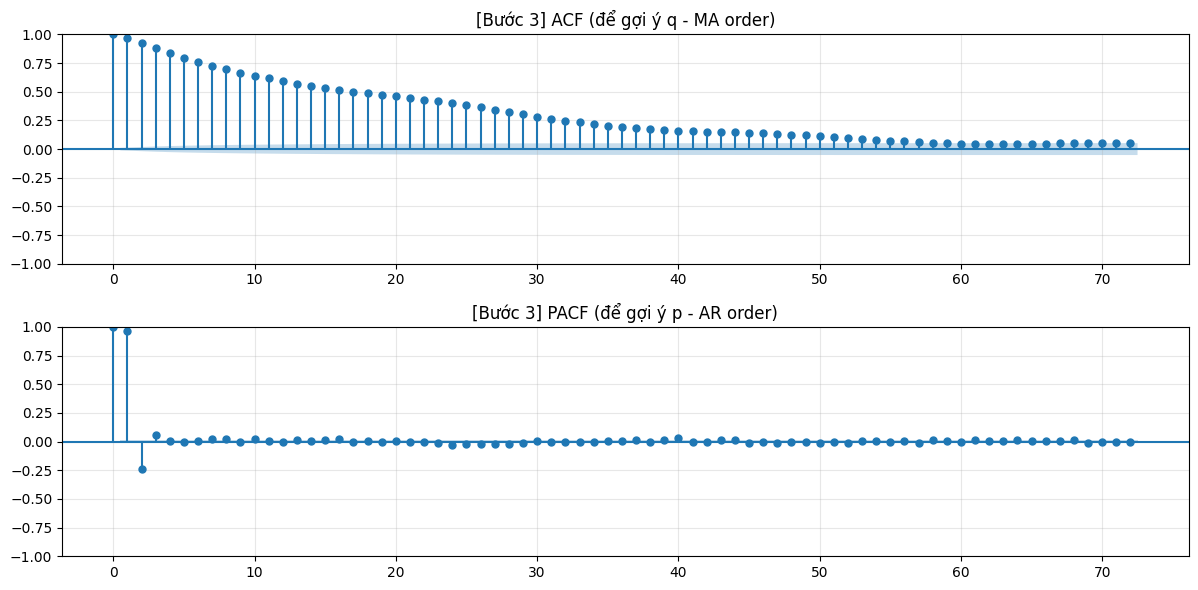


=> Phân tích ACF/PACF:
   - Nếu PACF 'cắt' sau lag k → p ≈ k
   - Nếu ACF 'cắt' sau lag k → q ≈ k
   - Trong thực tế, tín hiệu không rõ → Dùng grid search để chắc chắn

   *** Vùng tìm kiếm: p ∈ [0, 3], q ∈ [0, 3] ***


In [10]:
# BƯỚC 3: ACF/PACF để gợi ý p, q
print("\n[BƯỚC 3] ACF/PACF ĐỂ GỢI Ý p, q")
print("-"*70)

# Nếu d > 0, diff chuỗi trước khi vẽ ACF/PACF
if suggested_d > 0:
    x_for_acf = train_clean.diff(suggested_d).dropna()
    print(f"Sử dụng chuỗi sau differencing d={suggested_d} để vẽ ACF/PACF")
else:
    x_for_acf = train_clean
    print(f"Sử dụng chuỗi gốc (d=0) để vẽ ACF/PACF")

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# ACF
plot_acf(x_for_acf, lags=min(72, len(x_for_acf)//2), ax=axes[0], alpha=0.05)
axes[0].set_title('[Bước 3] ACF (để gợi ý q - MA order)')
axes[0].grid(True, alpha=0.3)

# PACF
plot_pacf(x_for_acf, lags=min(72, len(x_for_acf)//2), ax=axes[1], method='ywm', alpha=0.05)
axes[1].set_title('[Bước 3] PACF (để gợi ý p - AR order)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=> Phân tích ACF/PACF:")
print("   - Nếu PACF 'cắt' sau lag k → p ≈ k")
print("   - Nếu ACF 'cắt' sau lag k → q ≈ k")
print("   - Trong thực tế, tín hiệu không rõ → Dùng grid search để chắc chắn")
print(f"\n   *** Vùng tìm kiếm: p ∈ [0, {P_MAX}], q ∈ [0, {Q_MAX}] ***")

In [11]:
# BƯỚC 4: Grid search và chọn mô hình theo AIC/BIC
print("\n[BƯỚC 4] GRID SEARCH VÀ CHỌN MÔ HÌNH THEO AIC/BIC")
print("-"*70)

print(f"Thực hiện grid search với:")
print(f"  p ∈ [0, {P_MAX}]")
print(f"  d ∈ [0, {D_MAX}]")
print(f"  q ∈ [0, {Q_MAX}]")
print(f"  Tiêu chí: {IC.upper()}")
print()

# Grid search đã được thực hiện ở cell trước (gs variable)
print(f"Kết quả grid search:")
print(f"  Best order: ARIMA{best_order}")
print(f"  Best {IC.upper()}: {gs['best_score']:.2f}")
print(f"  (p, d, q) = ({best_order[0]}, {best_order[1]}, {best_order[2]})")

# So sánh với gợi ý từ bước 2
print(f"\nSo sánh với gợi ý:")
print(f"  d từ kiểm định dừng: {suggested_d}")
print(f"  d từ grid search:    {best_order[1]}")
if best_order[1] == suggested_d:
    print(f"  => Khớp! Grid search xác nhận d = {suggested_d}")
else:
    print(f"  => Khác! Grid search tìm được d tốt hơn theo {IC.upper()}")


[BƯỚC 4] GRID SEARCH VÀ CHỌN MÔ HÌNH THEO AIC/BIC
----------------------------------------------------------------------
Thực hiện grid search với:
  p ∈ [0, 3]
  d ∈ [0, 2]
  q ∈ [0, 3]
  Tiêu chí: AIC

Kết quả grid search:
  Best order: ARIMA(1, 0, 3)
  Best AIC: 294792.71
  (p, d, q) = (1, 0, 3)

So sánh với gợi ý:
  d từ kiểm định dừng: 0
  d từ grid search:    0
  => Khớp! Grid search xác nhận d = 0



[BƯỚC 5] CHẨN ĐOÁN PHẦN DƯ (RESIDUAL DIAGNOSTICS)
----------------------------------------------------------------------
Mô hình: ARIMA(1, 0, 3)
Số lượng residuals: 33648

** Thống kê residuals:
   Mean: 0.0085 (gần 0 là tốt)
   Std:  19.3393


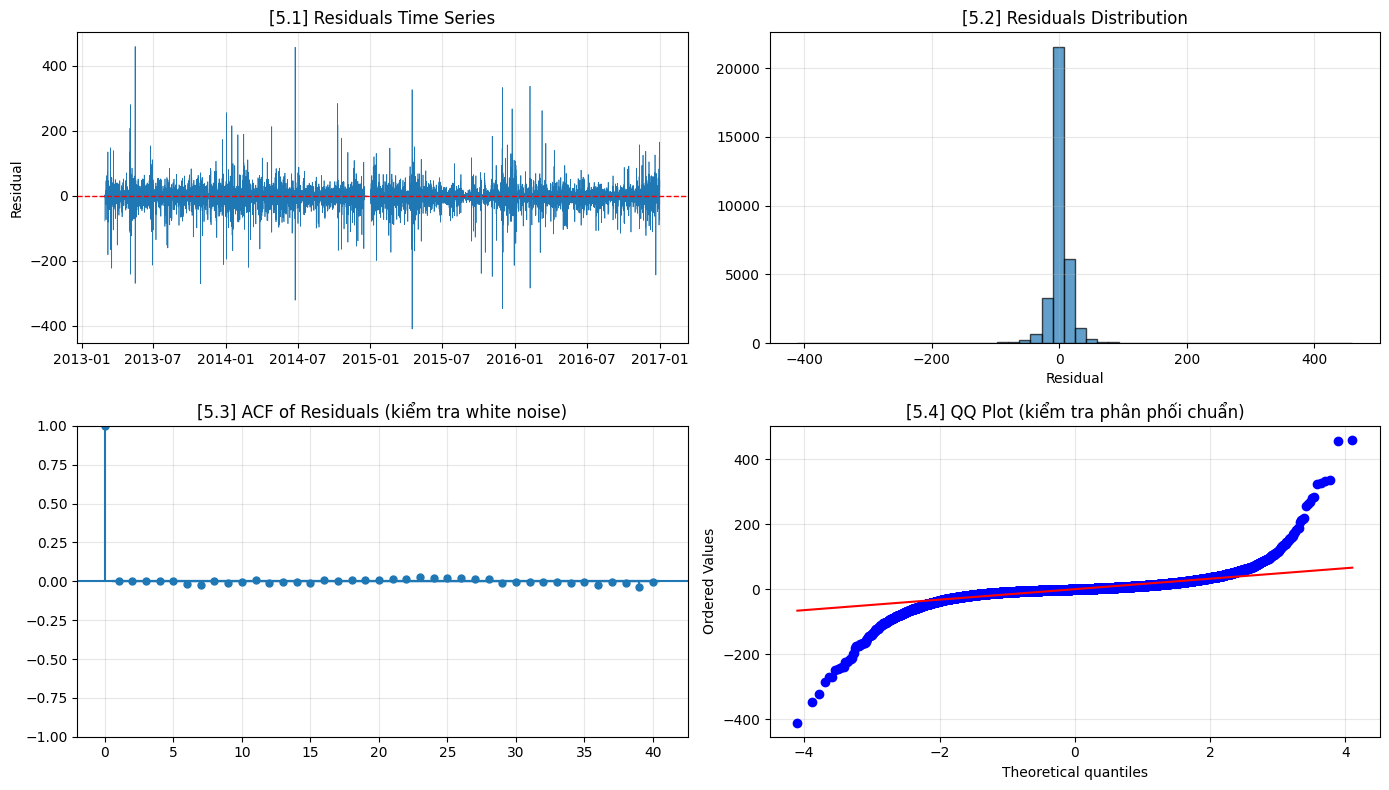


** Ljung-Box Test (H0: residuals là white noise):
       lb_stat     lb_pvalue
10   31.764656  4.382400e-04
20   53.078107  7.915063e-05
30  160.359395  9.481886e-20

=> Nếu p-value > 0.05 → Residuals là white noise → Mô hình tốt
=> Nếu p-value < 0.05 → Residuals còn cấu trúc → Cần cải thiện mô hình

KẾT LUẬN Q3: QUY TRÌNH RA QUYẾT ĐỊNH ARIMA
✓ Bước 1: Quan sát chuỗi → Nhận diện xu hướng, mùa vụ
✓ Bước 2: Kiểm định ADF/KPSS → Quyết định d
✓ Bước 3: Vẽ ACF/PACF → Gợi ý vùng p, q
✓ Bước 4: Grid search → Chọn (p,d,q) tốt nhất theo AIC/BIC
✓ Bước 5: Chẩn đoán residuals → Xác nhận mô hình bắt được cấu trúc

→ Mô hình cuối cùng: ARIMA(1, 0, 3)
→ AIC = 294792.71


In [12]:
# BƯỚC 5: Chẩn đoán phần dư (Residual Diagnostics)
print("\n[BƯỚC 5] CHẨN ĐOÁN PHẦN DƯ (RESIDUAL DIAGNOSTICS)")
print("-"*70)

# Prepare train_clean if not already defined
train_clean = train.dropna()

# Lấy residuals từ mô hình đã fit
from statsmodels.tsa.arima.model import ARIMA
model_resid = ARIMA(train_clean, order=best_order).fit()
residuals = model_resid.resid

print(f"Mô hình: ARIMA{best_order}")
print(f"Số lượng residuals: {len(residuals)}")
print(f"\n** Thống kê residuals:")
print(f"   Mean: {residuals.mean():.4f} (gần 0 là tốt)")
print(f"   Std:  {residuals.std():.4f}")

# Vẽ residuals
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# (1) Residuals time series
axes[0, 0].plot(residuals.index, residuals.values, linewidth=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('[5.1] Residuals Time Series')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# (2) Residuals histogram
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('[5.2] Residuals Distribution')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].grid(True, alpha=0.3)

# (3) ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=40, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('[5.3] ACF of Residuals (kiểm tra white noise)')
axes[1, 0].grid(True, alpha=0.3)

# (4) QQ plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('[5.4] QQ Plot (kiểm tra phân phối chuẩn)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
lb_result = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print(f"\n** Ljung-Box Test (H0: residuals là white noise):")
print(lb_result)
print(f"\n=> Nếu p-value > 0.05 → Residuals là white noise → Mô hình tốt")
print(f"=> Nếu p-value < 0.05 → Residuals còn cấu trúc → Cần cải thiện mô hình")

print("\n" + "="*70)
print("KẾT LUẬN Q3: QUY TRÌNH RA QUYẾT ĐỊNH ARIMA")
print("="*70)
print("✓ Bước 1: Quan sát chuỗi → Nhận diện xu hướng, mùa vụ")
print("✓ Bước 2: Kiểm định ADF/KPSS → Quyết định d")
print("✓ Bước 3: Vẽ ACF/PACF → Gợi ý vùng p, q")
print("✓ Bước 4: Grid search → Chọn (p,d,q) tốt nhất theo AIC/BIC")
print("✓ Bước 5: Chẩn đoán residuals → Xác nhận mô hình bắt được cấu trúc")
print(f"\n→ Mô hình cuối cùng: ARIMA{best_order}")
print(f"→ {IC.upper()} = {gs['best_score']:.2f}")
print("="*70)

In [13]:
# BƯỚC 4: Grid search và chọn mô hình theo AIC/BIC
print("\n[BƯỚC 4] GRID SEARCH VÀ CHỌN MÔ HÌNH THEO AIC/BIC")
print("-"*70)

print(f"Thực hiện grid search với:")
print(f"  p ∈ [0, {P_MAX}]")
print(f"  d ∈ [0, {D_MAX}]")
print(f"  q ∈ [0, {Q_MAX}]")
print(f"  Tiêu chí: {IC.upper()}")
print()

# Grid search đã được thực hiện ở cell trước (gs variable)
print(f"Kết quả grid search:")
print(f"  Best order: ARIMA{best_order}")
print(f"  Best {IC.upper()}: {gs['best_score']:.2f}")
print(f"  (p, d, q) = ({best_order[0]}, {best_order[1]}, {best_order[2]})")

# So sánh với gợi ý từ bước 2
print(f"\nSo sánh với gợi ý:")
print(f"  d từ kiểm định dừng: {suggested_d}")
print(f"  d từ grid search:    {best_order[1]}")
if best_order[1] == suggested_d:
    print(f"  => Khớp! Grid search xác nhận d = {suggested_d}")
else:
    print(f"  => Khác! Grid search tìm được d tốt hơn theo {IC.upper()}")


[BƯỚC 4] GRID SEARCH VÀ CHỌN MÔ HÌNH THEO AIC/BIC
----------------------------------------------------------------------
Thực hiện grid search với:
  p ∈ [0, 3]
  d ∈ [0, 2]
  q ∈ [0, 3]
  Tiêu chí: AIC

Kết quả grid search:
  Best order: ARIMA(1, 0, 3)
  Best AIC: 294792.71
  (p, d, q) = (1, 0, 3)

So sánh với gợi ý:
  d từ kiểm định dừng: 0
  d từ grid search:    0
  => Khớp! Grid search xác nhận d = 0



[BƯỚC 3] ACF/PACF ĐỂ GỢI Ý p, q
----------------------------------------------------------------------
Sử dụng chuỗi gốc (d=0) để vẽ ACF/PACF


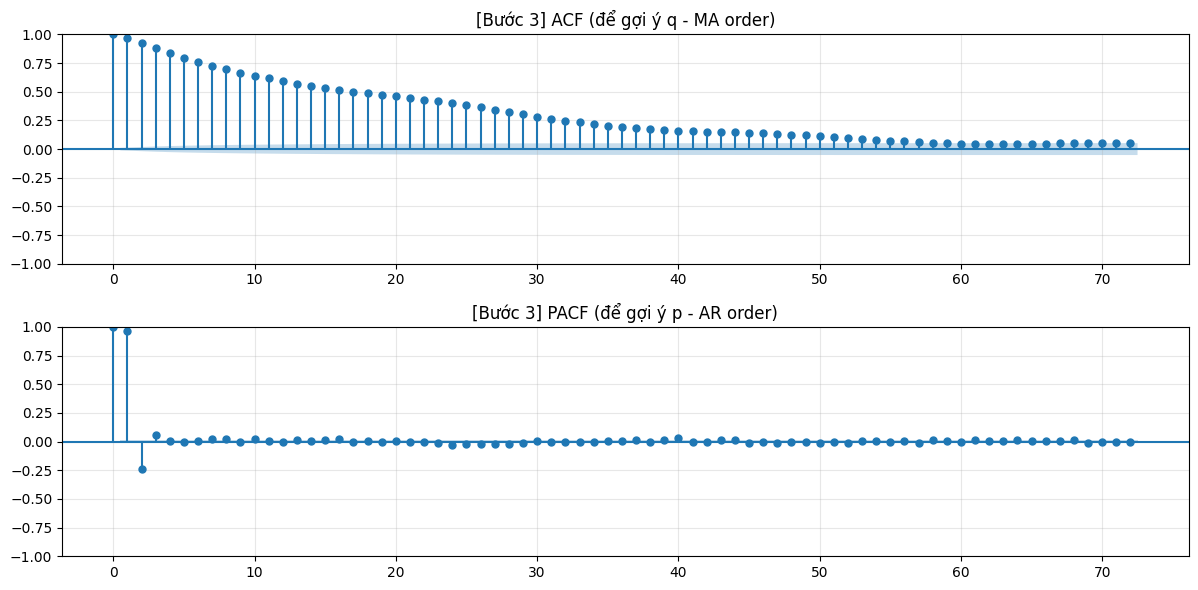


=> Phân tích ACF/PACF:
   - Nếu PACF 'cắt' sau lag k → p ≈ k
   - Nếu ACF 'cắt' sau lag k → q ≈ k
   - Trong thực tế, tín hiệu không rõ → Dùng grid search để chắc chắn

   *** Vùng tìm kiếm: p ∈ [0, 3], q ∈ [0, 3] ***


In [14]:
# BƯỚC 3: ACF/PACF để gợi ý p, q
print("\n[BƯỚC 3] ACF/PACF ĐỂ GỢI Ý p, q")
print("-"*70)

# Nếu d > 0, diff chuỗi trước khi vẽ ACF/PACF
if suggested_d > 0:
    x_for_acf = train_clean.diff(suggested_d).dropna()
    print(f"Sử dụng chuỗi sau differencing d={suggested_d} để vẽ ACF/PACF")
else:
    x_for_acf = train_clean
    print(f"Sử dụng chuỗi gốc (d=0) để vẽ ACF/PACF")

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# ACF
plot_acf(x_for_acf, lags=min(72, len(x_for_acf)//2), ax=axes[0], alpha=0.05)
axes[0].set_title('[Bước 3] ACF (để gợi ý q - MA order)')
axes[0].grid(True, alpha=0.3)

# PACF
plot_pacf(x_for_acf, lags=min(72, len(x_for_acf)//2), ax=axes[1], method='ywm', alpha=0.05)
axes[1].set_title('[Bước 3] PACF (để gợi ý p - AR order)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=> Phân tích ACF/PACF:")
print("   - Nếu PACF 'cắt' sau lag k → p ≈ k")
print("   - Nếu ACF 'cắt' sau lag k → q ≈ k")
print("   - Trong thực tế, tín hiệu không rõ → Dùng grid search để chắc chắn")
print(f"\n   *** Vùng tìm kiếm: p ∈ [0, {P_MAX}], q ∈ [0, {Q_MAX}] ***")

In [15]:
# BƯỚC 2: Kiểm định dừng và quyết định d
print("\n[BƯỚC 2] KIỂM ĐỊNH DỪNG VÀ QUYẾT ĐỊNH d")
print("-"*70)

from statsmodels.tsa.stattools import adfuller, kpss

# Lấy train set clean
train_clean = train.dropna()

# ADF test
adf_stat, adf_p, _, _, adf_crit, _ = adfuller(train_clean, autolag='AIC')
print(f"\n** ADF Test (H0: có unit root = không dừng):")
print(f"   ADF Statistic: {adf_stat:.4f}")
print(f"   p-value: {adf_p:.4f}")
print(f"   Critical values: {adf_crit}")
adf_conclusion = "DỪNG (bác bỏ H0)" if adf_p < 0.05 else "KHÔNG DỪNG (không bác bỏ H0)"
print(f"   => Kết luận ADF: {adf_conclusion}")

# KPSS test
kpss_stat, kpss_p, _, kpss_crit = kpss(train_clean, regression='c', nlags='auto')
print(f"\n** KPSS Test (H0: dừng):")
print(f"   KPSS Statistic: {kpss_stat:.4f}")
print(f"   p-value: {kpss_p:.4f}")
print(f"   Critical values: {kpss_crit}")
kpss_conclusion = "DỪNG (không bác bỏ H0)" if kpss_p > 0.05 else "KHÔNG DỪNG (bác bỏ H0)"
print(f"   => Kết luận KPSS: {kpss_conclusion}")

# Quyết định d
print(f"\n** QUYẾT ĐỊNH THAM SỐ d:")
if adf_p < 0.05 and kpss_p > 0.05:
    suggested_d = 0
    print(f"   - ADF bác bỏ 'unit root' VÀ KPSS không bác bỏ 'dừng'")
    print(f"   => Chuỗi ĐÃ DỪNG → d = 0")
elif adf_p >= 0.05 or kpss_p <= 0.05:
    suggested_d = 1
    print(f"   - ADF hoặc KPSS chỉ ra chuỗi CHƯA DỪNG")
    print(f"   => Cần differencing → d = 1 (hoặc d = 2 nếu vẫn không dừng)")
else:
    suggested_d = 1
    print(f"   - Kết quả không rõ ràng → Thử d = 1")

print(f"\n   *** Gợi ý: d = {suggested_d} ***")


[BƯỚC 2] KIỂM ĐỊNH DỪNG VÀ QUYẾT ĐỊNH d
----------------------------------------------------------------------

** ADF Test (H0: có unit root = không dừng):
   ADF Statistic: -18.9991
   p-value: 0.0000
   Critical values: {'1%': np.float64(-3.4305446600700438), '5%': np.float64(-2.8616260348274314), '10%': np.float64(-2.5668157936543383)}
   => Kết luận ADF: DỪNG (bác bỏ H0)

** KPSS Test (H0: dừng):
   KPSS Statistic: 0.3018
   p-value: 0.1000
   Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
   => Kết luận KPSS: DỪNG (không bác bỏ H0)

** QUYẾT ĐỊNH THAM SỐ d:
   - ADF bác bỏ 'unit root' VÀ KPSS không bác bỏ 'dừng'
   => Chuỗi ĐÃ DỪNG → d = 0

   *** Gợi ý: d = 0 ***


C:\Users\quang\AppData\Local\Temp\ipykernel_14316\2836023668.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(train_clean, regression='c', nlags='auto')


QUY TRÌNH RA QUYẾT ĐỊNH ARIMA - Q3

[BƯỚC 1] QUAN SÁT CHUỖI GỐC
----------------------------------------------------------------------
Chuỗi: Aotizhongxin - PM2.5
Length: 35,064 hours
Period: 2013-03-01 00:00:00 to 2017-02-28 23:00:00
Missing: 0 (0.00%)


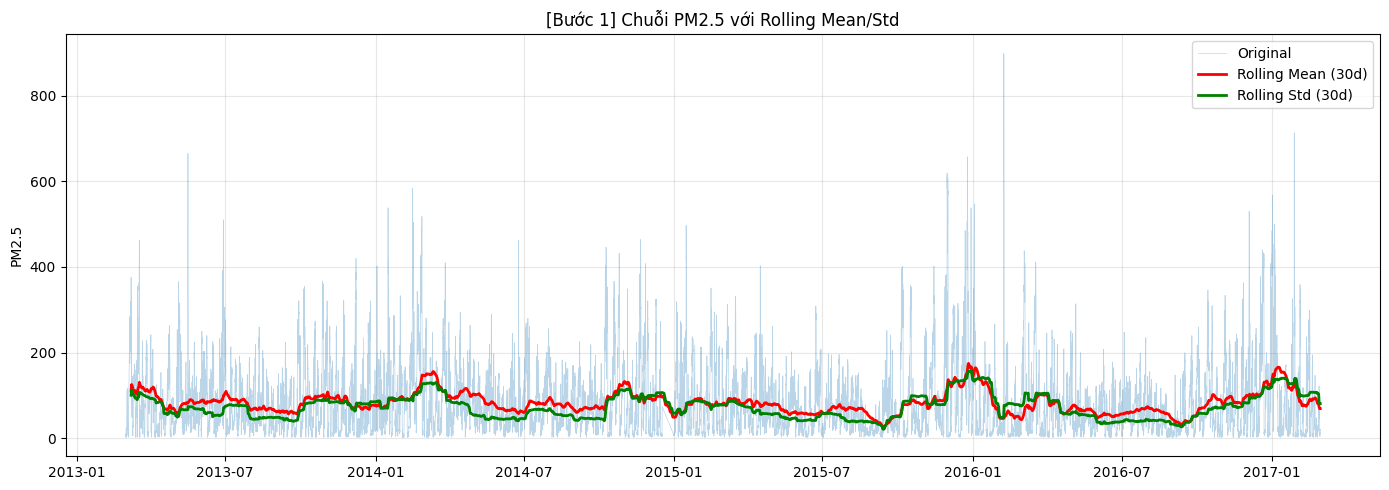


=> Nhận xét:
   - Rolling mean/std có thay đổi theo thời gian → Chuỗi có xu hướng không ổn định
   - Có các đỉnh spike cao → Cần lưu ý khi đánh giá


In [16]:
# Q3: Thực hiện quy trình ra quyết định ARIMA từng bước

print("="*70)
print("QUY TRÌNH RA QUYẾT ĐỊNH ARIMA - Q3")
print("="*70)

# BƯỚC 1: Quan sát chuỗi gốc
print("\n[BƯỚC 1] QUAN SÁT CHUỖI GỐC")
print("-"*70)
print(f"Chuỗi: {STATION} - {VALUE_COL}")
print(f"Length: {len(s):,} hours")
print(f"Period: {s.index.min()} to {s.index.max()}")
print(f"Missing: {s.isna().sum()} ({s.isna().mean()*100:.2f}%)")

# Rolling statistics để nhìn xu hướng
roll_mean_full = s.rolling(window=24*30, min_periods=24*7).mean()
roll_std_full = s.rolling(window=24*30, min_periods=24*7).std()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(s.index, s.values, alpha=0.3, linewidth=0.5, label='Original')
ax.plot(roll_mean_full.index, roll_mean_full.values, 'r-', linewidth=2, label='Rolling Mean (30d)')
ax.plot(roll_std_full.index, roll_std_full.values, 'g-', linewidth=2, label='Rolling Std (30d)')
ax.set_title(f'[Bước 1] Chuỗi {VALUE_COL} với Rolling Mean/Std')
ax.set_ylabel(VALUE_COL)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n=> Nhận xét:")
print("   - Rolling mean/std có thay đổi theo thời gian → Chuỗi có xu hướng không ổn định")
print("   - Có các đỉnh spike cao → Cần lưu ý khi đánh giá")

## Q3: Quy Trình Ra Quyết Định ARIMA

Theo yêu cầu Q3, sinh viên cần chứng minh quy trình ARIMA theo 5 bước:

### Bước 1: Quan sát chuỗi gốc để nhận diện xu hướng và mùa vụ
- **Mục đích**: Hiểu tính chất tổng quan của chuỗi
- **Công cụ**:
  - Vẽ chuỗi toàn giai đoạn và zoom vào 1-2 tháng
  - Vẽ rolling mean và rolling std (cửa sổ 7 ngày)
  - Vẽ average by hour-of-day để kiểm tra seasonality 24h
- **Kết luận**: Xem chuỗi có xu hướng tăng/giảm? Có dao động theo chu kỳ?

### Bước 2: Kiểm định dừng bằng ADF/KPSS để chọn d
- **ADF (Augmented Dickey-Fuller)**:
  - H0: Chuỗi có unit root (không dừng)
  - p < 0.05 → Bác bỏ H0 → Chuỗi dừng
  - p > 0.05 → Không bác bỏ H0 → Chuỗi không dừng (cần differencing)
  
- **KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**:
  - H0: Chuỗi dừng
  - p > 0.05 → Không bác bỏ H0 → Chuỗi dừng
  - p < 0.05 → Bác bỏ H0 → Chuỗi không dừng (cần differencing)
  
- **Chiến lược chọn d**:
  - Nếu ADF p < 0.05 VÀ KPSS p > 0.05 → d = 0 (chuỗi đã dừng)
  - Nếu không → Thử d = 1 (differencing bậc 1)
  - Nếu vẫn không dừng → Thử d = 2

### Bước 3: Xem ACF/PACF để đoán giá trị ứng viên cho p và q
- **PACF → gợi ý p (AR order)**:
  - Nếu PACF "cắt" rõ sau lag k → p ≈ k
  - PACF giảm dần → Thử p = 0, 1, 2, 3
  
- **ACF → gợi ý q (MA order)**:
  - Nếu ACF "cắt" rõ sau lag k → q ≈ k
  - ACF giảm dần → Thử q = 0, 1, 2, 3

- **Lưu ý**: Trong thực tế, tín hiệu không sắc nét → Cần grid search

### Bước 4: Grid search với p, q nhỏ và chọn mô hình theo AIC/BIC
- **Giữ d cố định** (từ Bước 2)
- **Thử tất cả tổ hợp (p, d, q)** với:
  - p = 0, 1, 2, ..., P_MAX
  - q = 0, 1, 2, ..., Q_MAX
  
- **Tiêu chí chọn**:
  - AIC (Akaike Information Criterion): Cân bằng goodness-of-fit và độ phức tạp
  - BIC (Bayesian Information Criterion): Phạt mô hình phức tạp mạnh hơn AIC
  - Chọn mô hình có AIC/BIC **thấp nhất**

### Bước 5: Chẩn đoán phần dư (residual diagnostics)
- **Mục đích**: Kiểm tra mô hình đã bắt được cấu trúc chính chưa
- **Phương pháp**:
  - Vẽ ACF của residuals → Nếu gần white noise (không tương quan) → Tốt
  - Ljung-Box test → p > 0.05 → Residuals là white noise
  - QQ plot → Kiểm tra phân phối chuẩn của residuals
  
- **Kết luận**: Nếu residuals ≈ white noise → Mô hình đã bắt được pattern chính